In [1]:
import torch
from torch import nn
from torch.utils import data
import torchvision as vis
import sys

# torch.manual_seed(117850791)
is_windows = sys.platform == "win32"
has_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if has_cuda else "cpu")
device

device(type='cuda', index=0)

In [2]:
from PIL import Image
import os

class FlatImageData(vis.datasets.VisionDataset):
  def __init__(self, root, transform, validation_reserved_images=31136):
    self.root = root
    self.images = os.listdir(root)
    self.images.sort(key=lambda x: int(x[6:-5]))# sort by frame no.
    self.transform = transform
    self.training_mode = True
    self.reserved_images = validation_reserved_images
        
  def __len__(self):
    if self.training_mode:
      return len(self.images) - self.reserved_images
    else:
      return self.reserved_images
    
  def pil_loader(self, path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

  def __getitem__(self, index):
    if self.training_mode:
      index += self.reserved_images
    
    image_name = self.images[index]
    image_path = f"{self.root}/{image_name}"
    image = self.pil_loader(image_path)
    if self.transform is not None:
         image = self.transform(image)

    return image

  def collate_fn(batch):
      return torch.as_tensor(batch)

In [3]:
validation_dataset = FlatImageData(root="/home/ubuntu/data/knnw-720p",
                             transform=vis.transforms.Compose([
                               vis.transforms.ToTensor(),
                               nn.AdaptiveAvgPool2d((64, 64))
                             ])
                       )

validation_dataset.training_mode = False
validation_dataset

Dataset FlatImageData
    Number of datapoints: 31136
    Root location: /home/ubuntu/data/knnw-720p

In [5]:
from torch.nn import functional as F
from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

class BetaVAE(nn.Module):

    num_iter = 0 # Global static variable to keep track of iterations

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 beta: int = 4,
                 gamma:float = 1000.,
                 max_capacity: int = 25,
                 capacity_max_iter: int = 1e5,
                 loss_type:str = 'B',
                 **kwargs) -> None:
        super(BetaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma
        self.loss_type = loss_type
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = capacity_max_iter

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim
            
        modules.append(nn.Flatten())

        self.encoder = nn.Sequential(*modules)
        
        self.fc_mu = nn.Linear(hidden_dims[-1]*16, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*16, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 16)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1))

    def encode(self, inputs: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(inputs)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return (inputs, mu, log_var)

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 512, 4, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Will a single z be enough ti compute the expectation
        for the loss??
        :param mu: (Tensor) Mean of the latent Gaussian
        :param logvar: (Tensor) Standard deviation of the latent Gaussian
        :return:
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, inputs: Tensor, **kwargs) -> Tensor:
        inputs, mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        
        self.current_inputs = inputs
        self.current_mu = mu
        self.current_log_var = log_var
        self.current_recon = self.decode(z)
        
        return self.current_recon

    def loss(self, *args, **kwargs) -> dict:
        self.num_iter += 1
        recons = self.current_recon
        input = self.current_inputs
        mu = self.current_mu
        log_var = self.current_log_var
        kld_weight = kwargs['kld_weight']  # Account for the minibatch samples from the dataset
        
        # since the image value is normalized between 0~1, BCE loss is better
        batch_size = recons.shape[0]
        recons_loss =F.binary_cross_entropy_with_logits(recons, input, reduction='sum') / batch_size
  
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        if self.loss_type == 'H': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        elif self.loss_type == 'B': # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight * (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

In [8]:
import os
model_store = "model_checkpoints"

class StoredModel:
  def __init__(self, model, optimizer, scheduler, criterion):
    self.model = model
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.criterion = criterion

In [6]:
def load_model(model_id, specific_epoch = None):
  global optimizer, scheduler
  epoch_start = -1
  for checkpoint in os.listdir(f"{model_store}/{model_id}"):
    if not checkpoint.startswith("epoch"):
      continue
    epoch = int(checkpoint.split("_")[1])
    if specific_epoch is None:
      # find the latest
      if epoch > epoch_start:
        epoch_start = epoch
        last_checkpoint = checkpoint
    else:
      if epoch == specific_epoch:
        epoch_start = epoch
        last_checkpoint = checkpoint
        break

  if epoch_start == -1:
    print(f"No checkpoints available for {model_id}!")
    return -1, None
  else:
    epoch_start += 1
    print(f"resuming from last checkpoint {last_checkpoint}")
    data = torch.load(f"{model_store}/{model_id}/{last_checkpoint}")
    
    model = data.model
    optimizer = data.optimizer
    scheduler = data.scheduler
    criterion = data.criterion
    
    model.to(device)
    return epoch_start, model, criterion

In [9]:
model_id = "baseline_BCE_H_loss_64x64_128_latent"
epoch_start, model, criterion = load_model(model_id)

resuming from last checkpoint epoch_34_tr-loss_5793.762743


## Run the model through validation dataset

In [11]:
from tqdm import tqdm

validataion_dataloader_args = dict(batch_size=128,
                             num_workers=0 if is_windows else 4) if has_cuda else dict(batch_size=64)
validataion_dataloader_args["shuffle"] = False

validataion_dataloader = data.DataLoader(validation_dataset, **validataion_dataloader_args)

# set model in training mode
model.eval()

latent_mu = list()
latent_log_var = list()

for i, x in enumerate(tqdm(validataion_dataloader, desc="Validate")):
  x = x.to(device)

  _, mus, log_vars = model.encode(x)
  latent_mu.append(mus.detach().cpu())
  latent_log_var.append(log_vars.detach().cpu())

Validate: 100%|██████████| 244/244 [04:19<00:00,  1.06s/it]


In [12]:
torch.save((torch.vstack(latent_mu), torch.vstack(latent_log_var)), f"temp_store/{model_id}_latent_vectors")

In [105]:
latent_mu, latent_log_var = torch.load(f"temp_store/baseline_BCE_H_loss_64x64_128_latent_latent_vectors")

In [118]:
latent_mu = latent_mu[:, top_10_divergent.indices]
latent_log_var = latent_log_var[:, top_10_divergent.indices]

In [119]:
from tqdm import tqdm

L2_divergence_latent = list()

for i in tqdm(range(31136 - 1), desc="L2"):
  image_1 = torch.cat((latent_mu[i], torch.exp(latent_log_var[i]).sqrt()))
  image_2 = torch.cat((latent_mu[i + 1], torch.exp(latent_log_var[i + 1]).sqrt()))
  
  diff = (image_1 - image_2).flatten()
  
  L2_divergence_latent.append(torch.linalg.norm(diff, 2).item())

L2: 100%|██████████| 31135/31135 [00:03<00:00, 8981.76it/s] 


In [91]:
from math import floor
scene_changes = []
with open("data/scene-change.csv") as f:
    lines = f.readlines()
    for line in lines[1:]:
        scenes = line.split(',')
        scene_changes.append([floor(int(scenes[0][6:12])/25*30+25), floor(int(scenes[1][6:12])/25*30+32)])

In [120]:
import numpy as np
L2_divergence_latent = np.array(L2_divergence_latent)

max_l2_per_scene_change = list()

for start_id, end_id in scene_changes:
  start_id -= 1
  max_l2_per_scene_change.append(max(L2_divergence_latent[start_id: end_id]))
  
max_l2_per_scene_change = np.array(sorted(max_l2_per_scene_change, reverse=True))

In [124]:
correct = list()
total = list()

for i, divergence in enumerate(max_l2_per_scene_change):
  correct.append(i + 1)
  total.append((L2_divergence_latent[700:] >= divergence).sum())

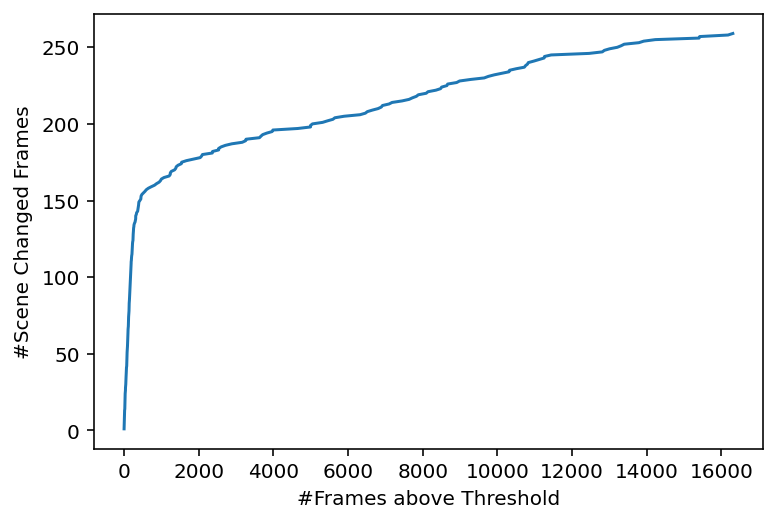

In [18]:
# all latent
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('#Scene Changed Frames')
ax1.set_xlabel('#Frames above Threshold')
plt.plot(total, correct)

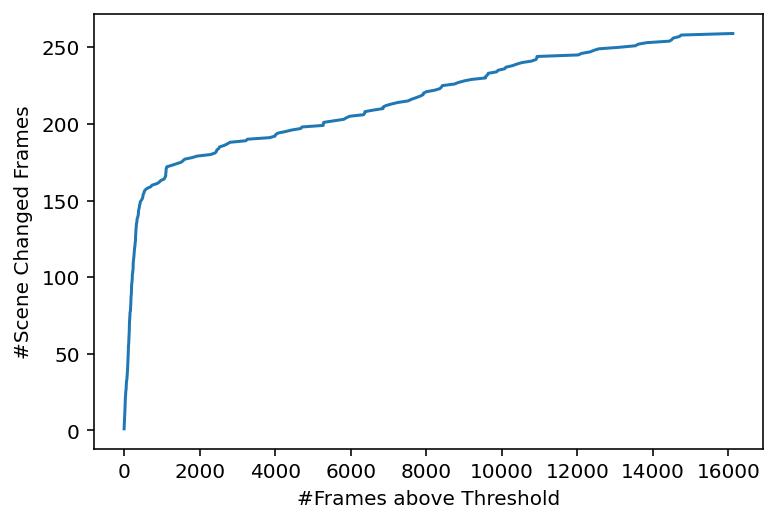

In [69]:
# top 10 selected by neighboring frames
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('#Scene Changed Frames')
ax1.set_xlabel('#Frames above Threshold')
plt.plot(total, correct)

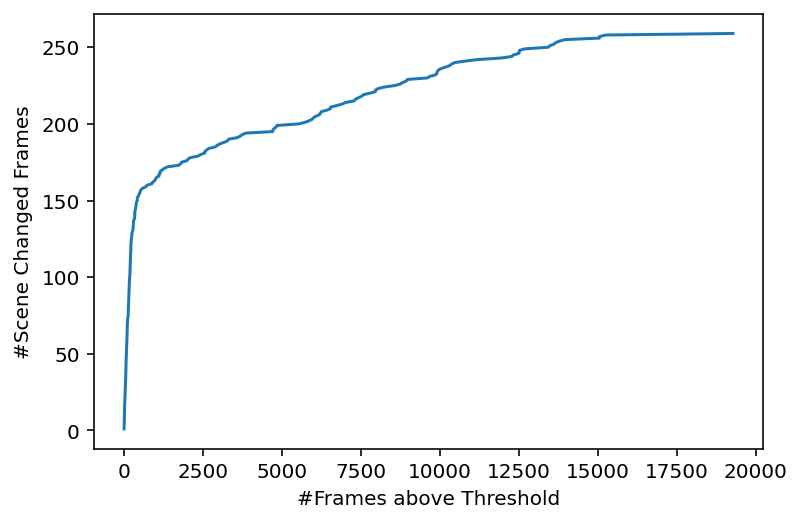

In [94]:
# top 10 selected by scene change boundary frames
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('#Scene Changed Frames')
ax1.set_xlabel('#Frames above Threshold')
plt.plot(total, correct)

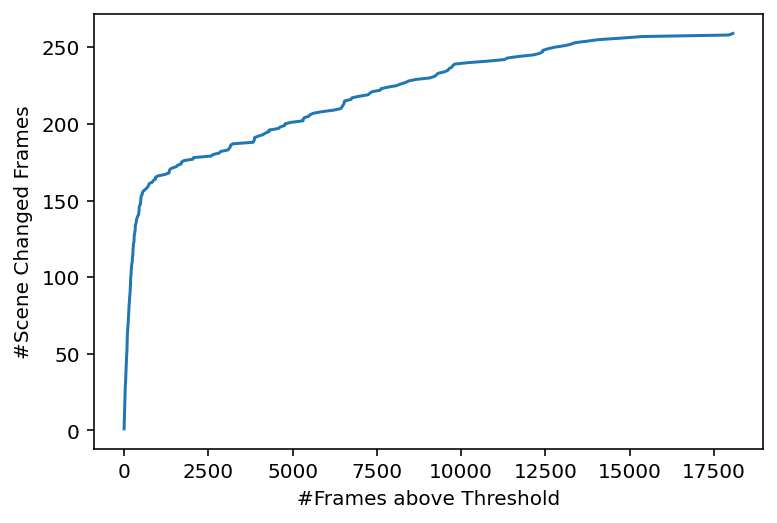

In [102]:
# top 5 selected by scene change boundary frames
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('#Scene Changed Frames')
ax1.set_xlabel('#Frames above Threshold')
plt.plot(total, correct)

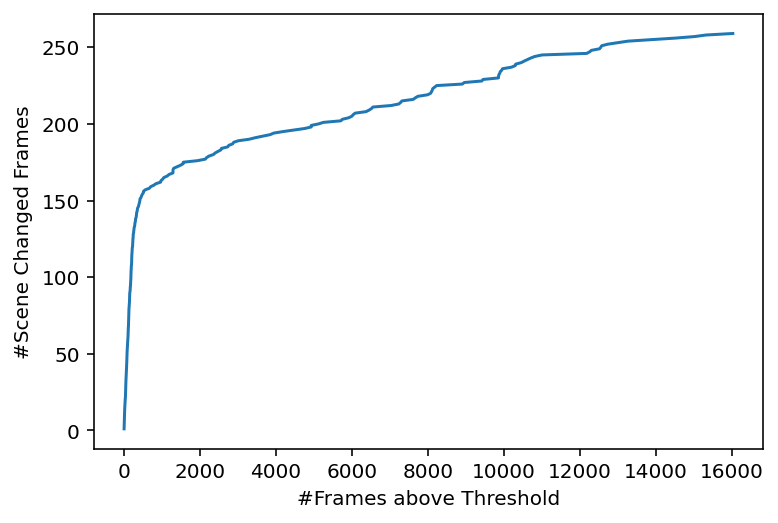

In [125]:
# top 20 selected by scene change boundary frames
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('#Scene Changed Frames')
ax1.set_xlabel('#Frames above Threshold')
plt.plot(total, correct)

In [23]:
validation_scene_changes = scene_changes[:100]
test_scene_changes = scene_changes[100:]

In [28]:
# collect the chanegd
scene_change_ids = list()

for start_id, end_id in validation_scene_changes:
  start_id -= 1
  scene_change_ids.append(L2_divergence_latent[start_id: end_id].argmax() + start_id)

In [110]:
w_dist_latent = torch.zeros(latent_mu.shape[1])

for frame_id_after in scene_change_ids:
  frame_id_before = frame_id_after - 1
  w_dist_latent += (latent_mu[frame_id_before] - latent_mu[frame_id_after]) ** 2 +\
      (torch.exp(latent_log_var[frame_id_before]).sqrt()
       - torch.exp(latent_log_var[frame_id_after]).sqrt()) ** 2

In [111]:
# result looks better when the frames are consecutive
top_10_divergent = w_dist_latent.topk(10)
top_10_divergent

torch.return_types.topk(
values=tensor([14.2700,  6.1761,  5.0874,  3.3913,  2.9716,  2.5970,  2.3758,  1.6480,
         1.3664,  1.3314]),
indices=tensor([108,  51,  83,  33,  38,  19,  57,  14,  58,  21]))

In [112]:
w_dist_latent = torch.zeros(latent_mu.shape[1])

for frame_id_before, frame_id_after in validation_scene_changes:
  w_dist_latent += (latent_mu[frame_id_before] - latent_mu[frame_id_after]) ** 2 +\
      (torch.exp(latent_log_var[frame_id_before]).sqrt()
       - torch.exp(latent_log_var[frame_id_after]).sqrt()) ** 2

In [116]:
# this seem weird
top_10_divergent = w_dist_latent.topk(20)
top_10_divergent

torch.return_types.topk(
values=tensor([303.0877, 297.8664, 232.9070, 202.2948, 196.5641, 188.4435, 185.6359,
        184.5257, 183.7697, 174.0805, 171.8506, 163.5816, 159.0642, 158.6717,
        152.6279, 148.7771, 148.2929, 127.1466, 125.9134, 102.4685]),
indices=tensor([  4,  42,  92,  89,  50,  38,  83,  52,  23,  29,  57, 108,  79,  33,
         65,  51,  20,  19, 104,  55]))